In [34]:
import numpy as np
from matplotlib import pyplot as plt

In [125]:
class KArmedBandit:
    def __init__(self, k, true_value_params=(0, 1), reward_std=1):
        self.k = k
        self.true_value_params = true_value_params
        self.reward_std = reward_std
        
        self.true_values = self._init_bandit()
        
    def _init_bandit(self):
        return np.random.normal(*self.true_value_params, self.k)
        
    def sample(self, n):
        return np.random.normal(self.true_values[n], self.reward_std)
    
    @property
    def optimal_arm(self):
        return self.true_values.argmax()
    
    @property
    def optimal_mean_value(self):
        return self.true_values.max()
    

class Strategy:
    def __init__(self, k, q_values, *args):
        self.k = k
        self.q_values = q_values
        self.action_counter = np.zeros(k, dtype=int)
        
        # For resetting the strategy
        self.initial_q_values = q_values.copy()
        
    def choose_arm(self, *args):
        """
        Implement the strategy for choosing which arm to pull next.
        
        Notes
        -----
        Decision should be based on current Q-values, plus any other information
        specified as an attribute of a subclass or by passing arguments.
        """
        raise NotImplementedError
        
    def update(self, reward, arm):
        """
        Given a reward from a selected arm, update q-values and action counter.
        """
        raise NotImplementedError
        
    def reset(self):
        """
        Reset the q-values and action counter to their initial values.
        """
        self.q_values = self.initial_q_values.copy()
        self.action_counter = np.zeros_like(self.action_counter, dtype=int)
        

class EpsilonGreedyStrategy(Strategy):
    def __init__(self, k, q_values, eps):
        super().__init__(k, q_values)
        
        self.eps = eps
    
    def choose_arm(self):
        """
        Select greedily 1 - eps pct of the time, else uniform random.
        
        Example
        -------
        Suppose we have a 3-armed bandit, q-values of [1.5, 3.0, 2.0], eps = 0.1.
            With probab 0.9, we select arm n=1 b.c. our q-value for n=1 is the highest (3.0).
            With probab 0.1, we select a random arm.
        Modifying eps tweaks the exploration vs. exploitation tradeoff.
        
        Returns
        -------
        arm : int
            The index of the selected arm.
        """
        outcome = np.random.uniform(0.0, 1.0)
        
        if outcome < eps:
            return np.random.randint(self.k)
        else:
            return np.random.choice(
                np.flatnonzero(self.q_values == self.q_values.max()),
            )
    
    def update(self, reward, arm):
        """
        Simple incremental implementation of the *sample-average method*.
        
        Example
        -------
        For each action, q-value is the average observed reward over all past iterations:
            Q_t(a) = sum of rewards when a taken prior to t / n times a taken prior to t.
        
        Implemented with: Q(a) <- Q(a) + 1/N(a) * [ r - Q(a) ]
        
        """
        self.action_counter[arm] += 1
        
        # Incremental update step of sample-average method.
        self.q_values[arm] += (1 / self.action_counter[arm]) * (reward - self.q_values[arm])
        

class Engine:
    def __init__(self, bandit, strategy):
        self.bandit = bandit
        self.strategy = strategy
        
    def _reset(self):
        self.episode_data = {
            'rewards': [],
            'optimal_arms': [],
        }
        self.strategy.reset()
        
    def run_episode(self, iterations):
        self._reset()
        
        for i in range(iterations):
            arm = self.strategy.choose_arm()
            reward = self.bandit.sample(arm)
            
            self.track(reward, arm)
            
            self.strategy.update(reward, arm)
            
        return self.episode_data
    
    def track(self, reward, arm):
        self.episode_data['rewards'].append(reward)
        self.episode_data['optimal_arms'].append(arm == self.bandit.optimal_arm)
        
    def run_episodes(self, episodes, iters_per_episode):
        multi_episode_data = {
            'rewards': np.zeros((episodes, iters_per_episode)),
            'optimal_arms': np.zeros((episodes, iters_per_episode)),
        }
        
        for episode in range(episodes):
            episode_data = self.run_episode(iters_per_episode)
            multi_episode_data['rewards'][episode, :] = np.array(episode_data['rewards'])
            multi_episode_data['optimal_arms'][episode, :] = np.array(episode_data['optimal_arms'])
            
        return multi_episode_data

        
    

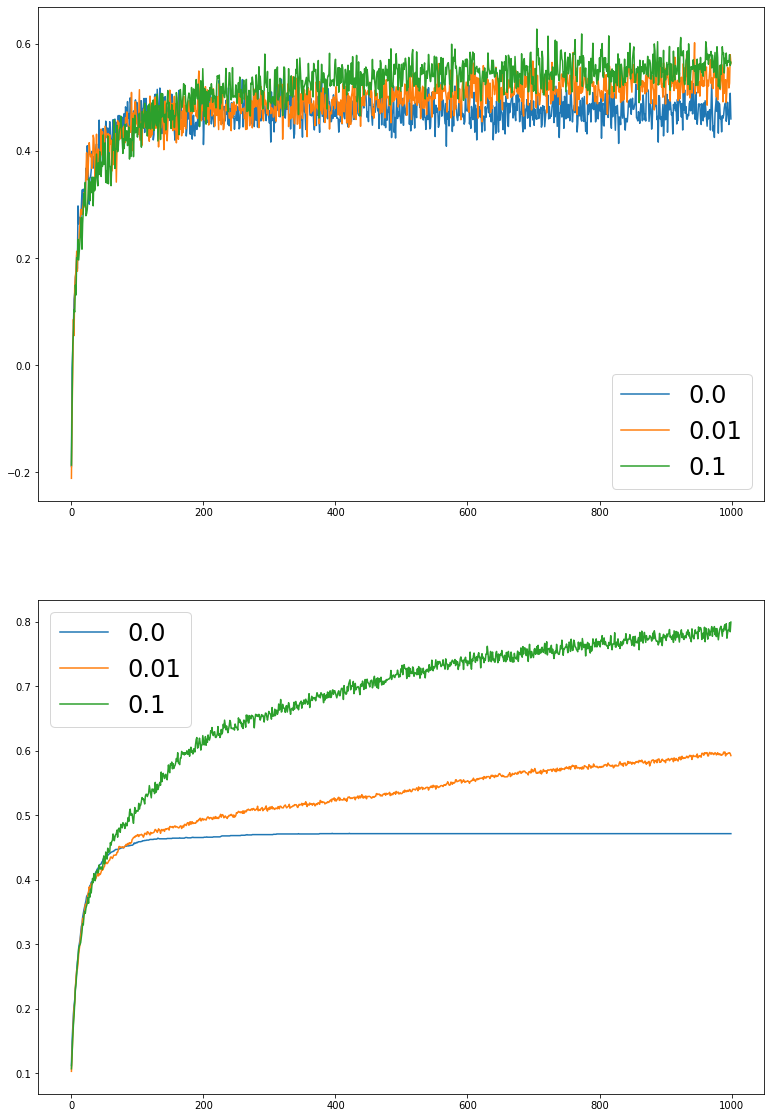

In [127]:
K = 10
ITERS = 1000
RUNS = 2000

bandit = KArmedBandit(K)

epsilons = [0.0, 0.01, 0.1]

fig, ax = plt.subplots(2, 1, figsize=(13, 20))
for eps in epsilons:
    q_values = np.zeros(K)
    strategy = EpsilonGreedyStrategy(K, q_values, eps)
    engine = Engine(bandit, strategy)
    
    data = engine.run_episodes(RUNS, ITERS)
        
    ax[0].plot(np.arange(ITERS), data['rewards'].mean(axis=0), label=eps)
    ax[1].plot(np.arange(ITERS), data['optimal_arms'].mean(axis=0), label=eps)

ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)